# Normalisation and DGE with EdgeR

In [1]:
library(edgeR)

Loading required package: limma


## Import metadata and gene info

In [2]:
#get the metadata
metadata <- read.table(file.path('data','SraRunTable.txt'), sep='\t', header=TRUE, comment.char = '', stringsAsFactors= FALSE)
#metadata <- dplyr::select(metadata, c('Run', 'treatment'))
rownames(metadata) <- metadata$Run
head(metadata, n = 5)

,BioSample,Experiment,MBases,MBytes,Run,SRA_Sample,Sample_Name,individual,treatment,Assay_Type,⋯,LibraryLayout,LibrarySelection,LibrarySource,LoadDate,Organism,Platform,ReleaseDate,SRA_Study,cell_type,source_name
,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
SRR8914928,SAMN11439856,SRX5696382,4330,1693,SRR8914928,SRS4635590,GSM3724893,Healthy volunteer #32,Unstimulated,RNA-Seq,⋯,PAIRED,cDNA,TRANSCRIPTOMIC,2019-04-16,Homo sapiens,ILLUMINA,2019-04-18,SRP192764,Live CD3+CD8+TCR-Valpha7.2,PBMC
SRR8914929,SAMN11439855,SRX5696383,3898,1516,SRR8914929,SRS4635592,GSM3724894,Healthy volunteer #42,Unstimulated,RNA-Seq,⋯,PAIRED,cDNA,TRANSCRIPTOMIC,2019-04-16,Homo sapiens,ILLUMINA,2019-04-18,SRP192764,Live CD3+CD8+TCR-Valpha7.2,PBMC
SRR8914930,SAMN11439854,SRX5696384,3745,1462,SRR8914930,SRS4635591,GSM3724895,Healthy volunteer #43,Unstimulated,RNA-Seq,⋯,PAIRED,cDNA,TRANSCRIPTOMIC,2019-04-16,Homo sapiens,ILLUMINA,2019-04-18,SRP192764,Live CD3+CD8+TCR-Valpha7.2,PBMC
SRR8914931,SAMN11439853,SRX5696385,3437,1344,SRR8914931,SRS4635594,GSM3724896,Healthy volunteer #32,T(anti-CD3/CD28 beads only),RNA-Seq,⋯,PAIRED,cDNA,TRANSCRIPTOMIC,2019-04-16,Homo sapiens,ILLUMINA,2019-04-18,SRP192764,Live CD3+CD8+TCR-Valpha7.2,PBMC
SRR8914932,SAMN11439852,SRX5696386,3358,1311,SRR8914932,SRS4635593,GSM3724897,Healthy volunteer #42,T(anti-CD3/CD28 beads only),RNA-Seq,⋯,PAIRED,cDNA,TRANSCRIPTOMIC,2019-04-16,Homo sapiens,ILLUMINA,2019-04-18,SRP192764,Live CD3+CD8+TCR-Valpha7.2,PBMC


In [3]:
#get gene info
genes <- read.table(file.path('data','gene_info.csv'), sep=',', header=TRUE, row.names = 1, , stringsAsFactors= FALSE)
head(genes)

,Gene.symbol
,<chr>
ENSG00000000003.14,TSPAN6
ENSG00000000005.5,TNMD
ENSG00000000419.12,DPM1
ENSG00000000457.13,SCYL3
ENSG00000000460.16,C1orf112
ENSG00000000938.12,FGR


## Generate design matrix
Before we fit negative binomial GLMs, we need to define our design matrix based on the
experimental design

In [4]:
#generate design matrix
treatments <- relevel(factor(metadata$treatment),'Unstimulated') #specifies that 'Unspecified' is the control to be used as intercept
design <- model.matrix(~treatments)
rownames(design) <- metadata$Run
#check that samples are assigned to the correct groups
design

,(Intercept),"treatmentsC(cytokines, IL-12/-15/-18/TL1A)",treatmentsT(anti-CD3/CD28 beads only),treatmentsTC(beads+cytokines)
SRR8914928,1,0,0,0
SRR8914929,1,0,0,0
SRR8914930,1,0,0,0
SRR8914931,1,0,1,0
SRR8914932,1,0,1,0
SRR8914933,1,0,1,0
SRR8914934,1,1,0,0
SRR8914935,1,1,0,0
SRR8914936,1,1,0,0
SRR8914937,1,0,0,1


## Prepare expression matrix as indicated in the tximport [vignette](https://bioconductor.org/packages/release/bioc/vignettes/tximport/inst/doc/tximport.html)

In [5]:
cts <- read.table(file.path('quant','txi_counts.csv'), sep=',', header=TRUE, row.names = 1)
head(cts)

,SRR8914928,SRR8914929,SRR8914930,SRR8914931,SRR8914932,SRR8914933,SRR8914934,SRR8914935,SRR8914936,SRR8914937,SRR8914938,SRR8914939
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000000003.14,57.966,54.984,64.000,53.000,71.000,62.134,24.000,15,39,18.000,12.000,35.000
ENSG00000000005.5,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0,0,0.000,0.000,0.000
ENSG00000000419.12,638.000,717.000,698.999,819.999,765.999,865.001,977.000,1131,1638,1257.000,1215.000,1405.000
ENSG00000000457.13,909.000,1073.001,812.000,827.000,877.000,997.364,707.000,780,672,759.999,573.999,647.991
ENSG00000000460.16,110.999,109.999,94.000,102.000,133.000,95.001,64.001,43,79,83.000,77.999,76.000
ENSG00000000938.12,46.000,33.000,52.000,38.000,48.000,39.001,36.000,21,27,18.001,2.000,20.000


In [6]:
normMat <- read.table(file.path('quant','txi_length.csv'), sep=',', header=TRUE, row.names = 1)
head(normMat)

,SRR8914928,SRR8914929,SRR8914930,SRR8914931,SRR8914932,SRR8914933,SRR8914934,SRR8914935,SRR8914936,SRR8914937,SRR8914938,SRR8914939
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000000003.14,1993.5900,2052.9671,2037.0042,2024.3470,1639.1534,2059.3122,1853.6300,2022.4640,1934.6152,2018.2330,1207.9883,2086.9038
ENSG00000000005.5,755.5001,755.5001,755.5001,755.5001,755.5001,755.5001,755.5001,755.5001,755.5001,755.5001,755.5001,755.5001
ENSG00000000419.12,899.6938,899.9257,889.2078,894.7997,883.2173,896.3195,883.9067,893.5549,885.6504,891.3221,893.9613,885.2500
ENSG00000000457.13,3515.0247,3694.3844,3840.7632,3409.0813,3765.5830,3478.3599,3349.1278,3116.4056,3041.5944,3302.0231,3245.4958,3257.4610
ENSG00000000460.16,1697.5538,2343.9999,2125.7737,2573.1564,2784.0166,2335.6856,1800.8588,2281.4003,2012.6638,2096.4975,2690.0189,1904.0162
ENSG00000000938.12,2366.7213,2274.3947,1896.0844,2090.9448,2040.6254,2238.4494,1211.9094,1837.4640,1952.7460,1383.5195,919.6940,1698.6849


In [7]:
#normalise
normMat <- normMat/exp(rowMeans(log(normMat)))
o <- log(calcNormFactors(cts/normMat)) + log(colSums(cts/normMat))
y <- DGEList(cts, group= metadata$treatment, genes= genes)
y <- scaleOffset(y, t(t(log(normMat)) + o))
# filtering
keep <- filterByExpr(y)
y <- y[keep, ]

y is now ready for estimate dispersion functions see edgeR [User's Guide](https://www.bioconductor.org/packages/release/bioc/vignettes/edgeR/inst/doc/edgeRUsersGuide.pdf)

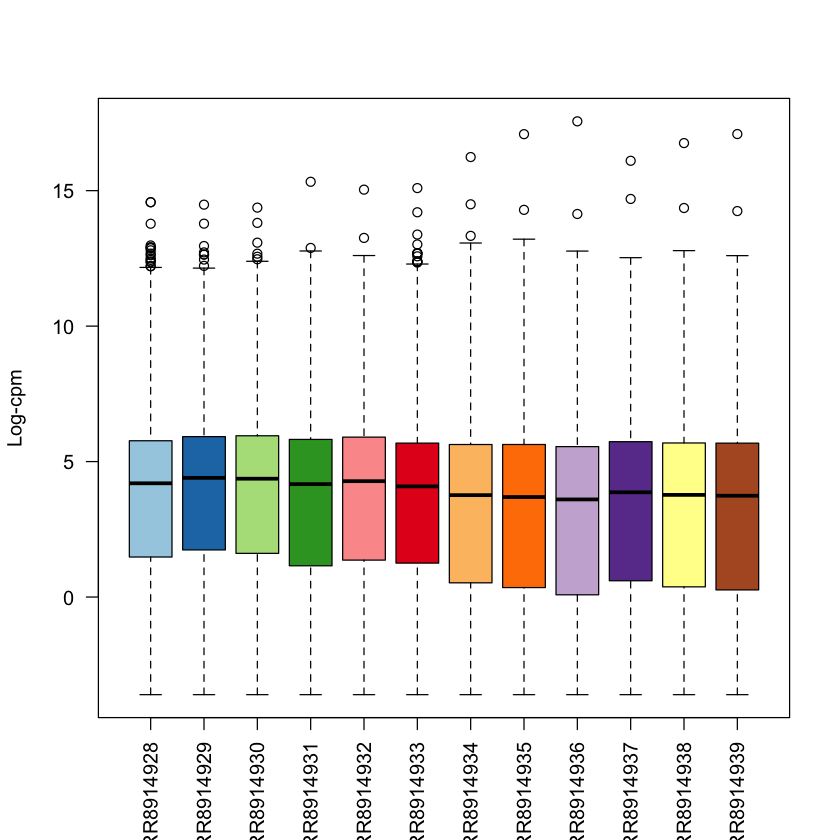

In [8]:
library(RColorBrewer)
nsamples <- ncol(cts)
col <- brewer.pal(nsamples, "Paired")
boxplot(cpm(y$counts, log=TRUE),las=2, col=col)
title(ylab="Log-cpm")

## Estimate dispersion
We estimate the NB dispersion for the dataset.

In [9]:
y <- estimateDisp(y, design, robust=TRUE)
y$common.dispersion

[1] 0.1069902

The square root of the common dispersion gives the coefficient of variation of biological
variation. 
The dispersion estimates can be viewed in a BCV plot:

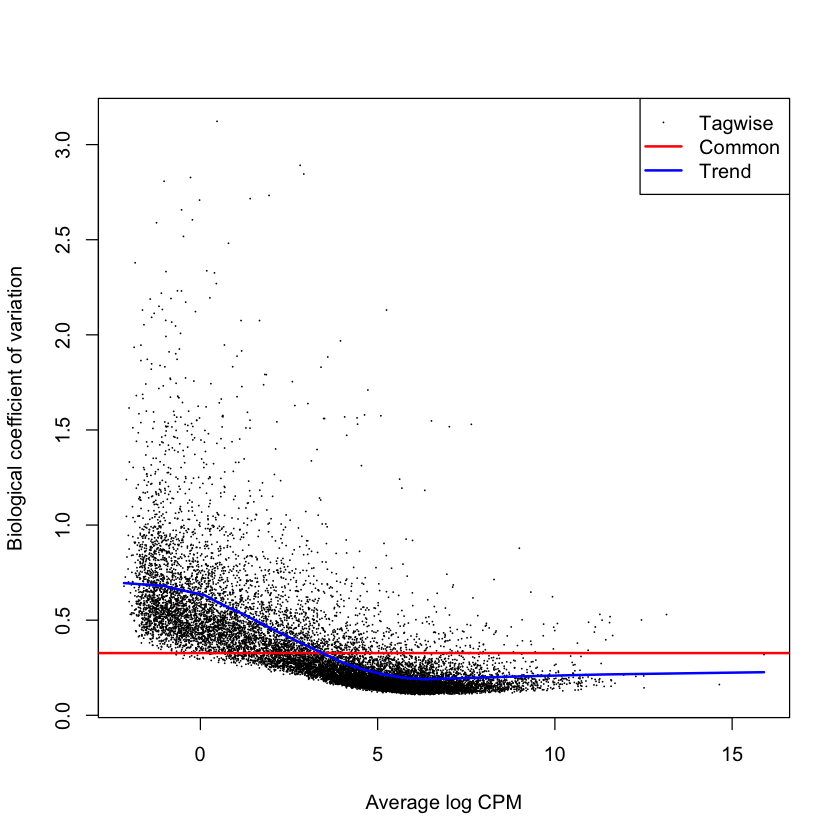

In [10]:
plotBCV(y)

## Differential expression
Now proceed to determine differentially expressed genes. Fit genewise glms:

In [11]:
fit <- glmFit(y, design)

Conduct likelihood ratio tests and show the top genes:

In [12]:
lrt <- glmLRT(fit)
topTags(lrt)

,Gene.symbol,logFC,logCPM,LR,PValue,FDR
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000226979.8,LTA,6.853182,9.599096,482.1463,7.289849e-107,1.074232e-102
ENSG00000135069.13,PSAT1,6.692187,8.389228,465.8902,2.512404e-103,1.851139e-99
ENSG00000136810.12,TXN,4.176612,7.540039,455.9326,3.690135e-101,1.812594e-97
ENSG00000116761.11,CTH,5.230797,5.364700,420.1734,2.237187e-93,6.906634e-90
ENSG00000081059.19,TCF7,-5.883723,8.077542,420.0808,2.343456e-93,6.906634e-90
ENSG00000130766.4,SESN2,3.824255,7.217278,419.2197,3.608210e-93,8.861764e-90
ENSG00000065911.11,MTHFD2,6.425701,9.517850,407.2817,1.431649e-90,3.013825e-87
ENSG00000111536.4,IL26,6.855521,6.914317,390.9165,5.228127e-87,9.630211e-84
ENSG00000163346.16,PBXIP1,-3.789272,8.699111,383.6406,2.006075e-85,3.284613e-82


### Examining the number of DE genes

For a quick look at differential expression levels, the number of significantly up- and down-regulated genes can be summarised in a table. Significance is defined using an adjusted p-value cutoff that is set at 5% by default.

In [13]:
summary(decideTests(lrt))

       treatmentsTC(beads+cytokines)
Down                            4660
NotSig                          5641
Up                              4435

In [15]:
#export DGE results
write.csv(as.data.frame(lrt$table),file= file.path('data','DGE_edgeR.csv'))

Plot log-fold change against log-counts per million, with DE genes highlighted:

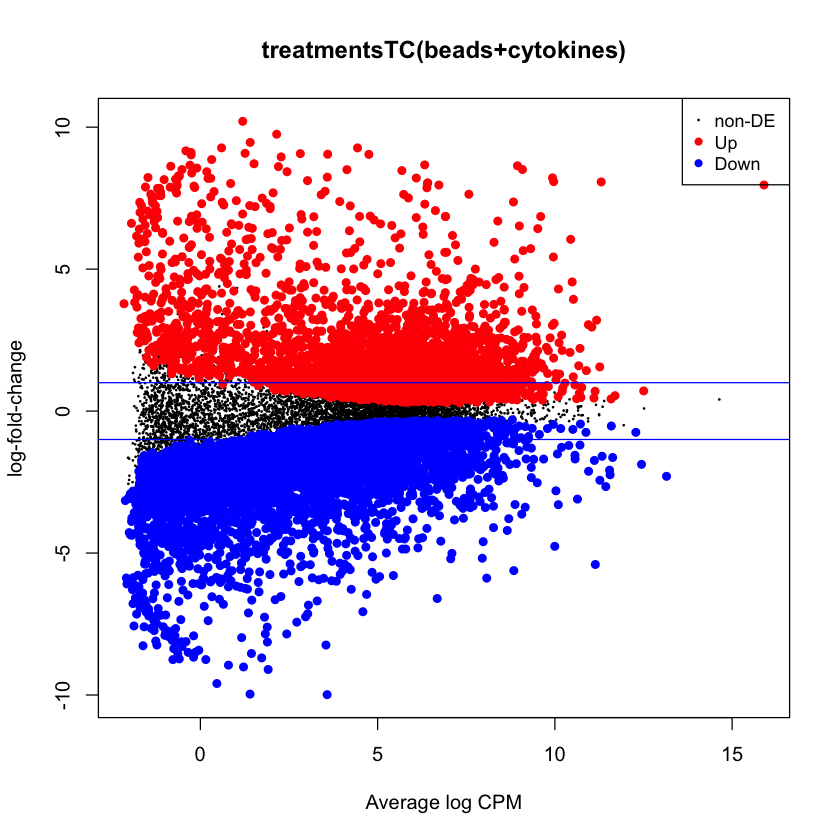

In [16]:
#MA plot
plotMD(lrt)
abline(h=c(-1, 1), col="blue")